<a href="https://colab.research.google.com/github/Topolewski-Kamil/robot-reinforcement-learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Intelligence COM3240

## Lab 8: Reinforcement Learning


### Introduction

The main characteristic of reinforcement learning is that learning comes from interaction. The learner (or agent) has to achieve a specific goal by performing correct actions. If the goal is reached then he obtains reward. Given that there is no prior knowledge of which action is correct or wrong the agent needs to explore in order to reach the reward. It is possible for the agent to be rewarded not only when he reached the goal (future reward) but also by performing correct actions towards the goal (immediate reward).


### Basic concepts and algorithms

Reinforcement learning uses functions called value functions. Value functions are state-action pair functions that estimate how good a particular action will be in a given state, under a policy. Mathematically they are described by the notation $Q^{\pi}(s,a)$.

The value functions can be estimated by temporal difference (TD) learning methods. The TD methods calculate an estimation of the final reward at each state and the state-action value is updated for every step. They can be split up into two broad categories of methods, the on-policy methods and the off-policy methods. In the first category the agent learns the value of the policy that is used to make decisions, while in the second category the agent can learn different policies for behaviour and estimation. An example of an off-policy algorithm for TD learning is the Q-learning algorithm while an example of an on-policy algorithm for TD learning is the SARSA algorithm. The procedural forms of these two algorithms are described below:

<img src="./algoQ.png" width="500"/>

<img src="./algoSARSA.png" width="500"/>

where $\eta$ is the learning rate, $\gamma$ is the discount factor and $max_a$ is the maximum reward that is attainable in the state following the current one.


### The $\epsilon$-greedy policy

SARSA, being an on-policy algorithm does not explore new actions but always chooses the action with the highest expected reward. A way to include exploration is to choose the action with the highest expected reward at first, and then have a probability of following the same action or another, random one, the rest of the time. This approach is achieved with the $\epsilon$-greedy policy where a greedy action is selected with probability $1-\epsilon$, where $0 \leq \epsilon \leq 1$, and a random action is selected the rest of the times.


### Eligibility trace and the SARSA($\lambda$) algorithm 

When TD learning algorithms like SARSA observes a high or low reward, the only state-action pair which has its $Q(s,a)$ value updated is the state-action pair $(s,a)$ which leads to the reward. The next time the algorithm reaches state $s$, the state-action pair which leads to state $s$ will have its Q-value updated. The idea now is to update all Q-values of the trajectory once the reward is received. In order for this to be achieved an eligibility trace $e(s,a)$ needs to be maintained for each state-action pair. This trace indicates how much the current reward will influence $Q(s,a)$. The eligibility trace can be used in combination with the SARSA algorithm. The procedural form of the new algorithm named SARSA($\lambda$) is described below:

<img src="./algoSARSAl.png" width="500"/>

where $\eta$ is the learning rate, $\gamma$ is the discount factor and $\lambda$ is an indicator for the influence of the current reward.

## Laboratory 8

#### Exercise

<img src="./robot.png" width="500"/>

A robot moves in a square room with four possible actions, North, South, East and West. It has to learn a ”homing” task, i.e. to return to a particular location, where for instance it can charge its battery (reward location). There are no explicit landmarks, but to simplify the task we assume that the robot has been familiarised with the environment and therefore it has some internal representation of its position own position in the space, but no explicit memory of the reward location. Your task is to write a program where the above-mentioned goal-oriented behaviour (homing) can be learned by using a reinforcement learning algorithm, in the following way:

1. The robot is placed at a random location (segment) of the room.
2. It explores the space/learns the goal oriented behaviour by using the SARSA algorithm with Q-values.
3. Reward is given when the robot reaches the segment where the charger is located.
3. Trial ends when reward is reached (or a predefined number of steps is exceeded) and procedure starts from 1 until a predefined number of trials is reached.

At the end, you should plot the number of steps it took the robot to reach its target vs the trial number (learning curve). Successful learning means that the required number of steps is reduced as the trial number increases. We will call this procedure one run of the algorithm.

Tasks:

1. Develop the main SARSA routine and test your robot's homing behaviour over multiple repetitions. Plot the number of steps taken at each trial averaged over these repetitions.
2. Implement the $\epsilon$-Greedy algorithm instead of the greedy policy.
3. Increase the grid size to 10 by 10, how does this affect the number of trials needed for the robot to learn the environment? You might need to increase the maximum number of steps allowed and/or the total number of trials.
4. Implement an eligibility trace. Plot the difference in performance.
5. Find the optimal learning rate, discount factor and epsilon for the $\epsilon$-Greedy algorithm.

#### Script that returns the learning curve for each trial

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def homing_nn(n_trials, n_steps, learning_rate, eps, gamma, Qlearning):

    lam = 0.9
    
    ## Definition of the environment
    N = 4                               #height of the gridworld ---> number of rows
    M = 12                               #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    
    # Initialise a matrix where each row is one of the possible state vectors.
    states_matrix = np.eye(N_states)

    # 4 possible actions to move to each adjacent square
    N_actions = 4                                           
    action_change = np.array( [ [ 0, +1],
                                [+1, 0],
                                [ 0, -1],
                                [-1, 0]])
    action_labels = ['Right', 'Down', 'Left', 'Up'] 
    
    
    End = np.array([0, 11])                                     #terminal state--->reward
    s_end = np.ravel_multi_index(End, dims=(N, M), order='F')  #terminal state. Conversion in single index

    ## Rewards
    R_end = 100                              #only when the robot reaches the charger, sited in End state

    ## Variables
    # Weight matrix to predict the Q-values for eah action in a given state
    weights = np.random.rand(N_actions, N_states)*0.0
    
    # TODO: When the SARSA routine is working, build in an eligibility trace
    # Remember, there is an eligibility value for each state-action pair so 
    # it will be a matrix the same shape as the weights.
    # e = np.zeros((N_actions, N_states))
    
    # Learning curve: Here we will store the number of steps taken per trial
    # If the agent learns the Q-values it should be able to reach the end
    # in fewer steps. 
    learning_curve = np.zeros((n_trials))
    
    ## SARSA Algorithm
    Rewards = np.zeros((1,nTrials))
    RewardsSmooth = np.zeros((1,nTrials))
    
    # Since the rewards will be either 0 or 1, we will employ
    # an exponential moving average to smooth over multiple trials
    tau = 0.05

    # Start trials
    for trial in range(n_trials):
        # Initialization
        Start = np.array([0,0])  #random start
        s_start = np.ravel_multi_index(Start, dims=(N,M), order='F')    #conversion in single index

        state = Start                                                   #set current state
        s_index = s_start                                               #conversion in single index
        step = 0

        # print('Start: ', Start)

        # First step for SARSA or Q-learning
        
        # convert the state into an input vector
        x = states_matrix[s_index]         
   
        # TODO: Q-value using a neural network
        Q = np.matmul(weights, x)
        
        # TODO: Greedy policy to select the most rewarding action
        action = np.argmax(Q)
        
        #eps-greedy policy implementation
        greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
        if greedy:
            action = np.argmax(Q)                           #pick best action
        else:
            action = np.random.randint(N_actions)           #pick random action

        # TODO: setup the output array (1 where action was taken, 0 otherwise)
        output = np.zeros((N_actions))                     
        output[action] = 1
        # print('Action: ', action)
        
        # Begin steps iteration 
        for step in range(n_steps):
            
            # e = e + np.outer(output, x)
            
            # Keep track of the current number of steps taken
            learning_curve[trial] = step + 1
            
            # print('Old state: ', state)
            # Apply selected action to move to give a new state 
            state_new = state + action_change[action]
            # print('New state: ', state_new)
            
            #put the robot back in grid if it goes out. Consider also the option to give a negative reward
            if state_new[0] < 0:
                state_new[0] = 0
            if state_new[0] >= N:
                state_new[0] = N-1
            if state_new[1] < 0:
                state_new[1] = 0
            if state_new[1] >= M:
                state_new[1] = M-1
            
            # Convert the new position into an index
            s_index_new = np.ravel_multi_index(state_new, dims=(N,M), order='F')
            cliff = [4,8,12,16,20,24,28,32,36,40]
            # TODO: Main SARSA or Q-learning routine
            
            # TODO: If the new position is the final state then agent receives the reward 
            # and the weights are updated as an immediate reward then break the for loop
            if (s_index_new == s_end):
                
                # convert the state into an input vector (S')
                x_new = states_matrix[s_index_new]
                
                # r = R_end
                
                # TODO: Calculate the weight update with the immediate reward
                dw = learning_rate * (r - Q[action]) * np.outer(output, x)
                # dw = learning_rate * (r - Q[action]) * e
                weights += dw

                # Store reward
                # Rewards[0,trial] += r 
                break

            elif s_index_new in cliff:
                # convert the state into an input vector (S')
                x_new = states_matrix[s_index_new]
                
                r = -100
                
                # TODO: Calculate the weight update with the immediate reward
                dw = learning_rate * (r - Q[action]) * np.outer(output, x)
                # dw = learning_rate * (r - Q[action]) * e
                weights += dw

                # Store reward
                Rewards[0,trial] += r 
                if (trial == 0):
                  RewardsSmooth[0,trial] = r
                else:
                  RewardsSmooth[0,trial] = (Rewards[0,trial])*tau + RewardsSmooth[0,trial-1]*(1-tau)
                break

            # TODO: if it is not the end step then the new Q-values and actions 
            # should be calculated for the weight updates
            else:
                # Otherwise it is a normal step and we can need to select the next actions
                r = -1
                # Store reward
                Rewards[0,trial] += r 

                if (trial == 0):
                  RewardsSmooth[0,trial] = r
                else:
                  RewardsSmooth[0,trial] = (Rewards[0,trial])*tau + RewardsSmooth[0,trial-1]*(1-tau)

                # convert the state into an input vector (S')
                x_new = states_matrix[s_index_new]
                
                # TODO: Predict the new Q-values
                Q_new = np.matmul( weights, x_new)
                
                # TODO: For SARSA we need to select the next action (A')
                #action_new = np.argmax(Q_new)


                #eps-greedy policy implementation
                greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
                if greedy:
                    action_new = np.argmax(Q_new)                           #pick best action
                else:
                    action_new = np.random.randint(N_actions)           #pick random action

                if Qlearning:
                  action_new2 = np.argmax(Q_new)                           #pick best actioN
                  dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new2]) * np.outer(output, x)
                else: 
                  dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new]) * np.outer(output, x)
                  
                # TODO: Setup the output vector
                output_new = np.zeros((N_actions))
                output_new[action_new] = 1
                
                # TODO: Calculate the weight updates using SARSA
                # dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new]) * np.outer(output, x)
                # dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new]) * e
                weights += dw
            
            # e *= gamma*lam
            
            # Replace the old values with the new ones ready for the next step
            state = np.copy(state_new)
            action = np.copy(action_new)
            Q = np.copy(Q_new)
            output = np.copy(output_new)
            x = np.copy(x_new)
            s_index = s_index_new

    return learning_curve , Rewards, RewardsSmooth

#### Call the function homing_nn


In [105]:
# Parameter setup
nRepetitions = 5;   # number of runs for the algorithm
nTrials = 500;      # should be integer >0
nSteps = 50;        # maximum number of allowed steps
learningRate = 0.3; # should be real, Greater than 0
epsilon = 0.1;     # should be real, Greater or Equal to 0; epsion=0 Greedy, otherwise epsilon-Greedy
gamma = 1;        # should be real, positive, smaller than 1

learning_curves = np.zeros((nRepetitions, nTrials))

totalRewards = np.zeros((nRepetitions, nTrials))
totalSmoothRewards = np.zeros((nRepetitions, nTrials))

# TODO: average number of steps to finish the task per trial for nRepetitions
for i in range(nRepetitions):
    learning_curves[i], totalRewards[i,:], totalSmoothRewards[i,:] = homing_nn(nTrials, nSteps, learningRate, epsilon, gamma, False)

In [106]:
learning_curvesQ = np.zeros((nRepetitions, nTrials))

totalRewardsQ = np.zeros((nRepetitions, nTrials))
totalSmoothRewardsQ = np.zeros((nRepetitions, nTrials))

# TODO: average number of steps to finish the task per trial for nRepetitions
for i in range(nRepetitions):
    learning_curvesQ[i], totalRewardsQ[i,:], totalSmoothRewardsQ[i,:] = homing_nn(nTrials, nSteps, learningRate, epsilon, gamma, True)

In [ ]:
totalRewards[0]

In [ ]:
totalRewardsQ[0]

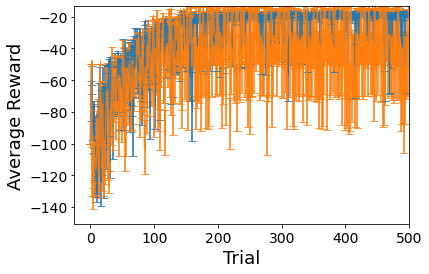

In [108]:
# Plot the average reward as a function of the number of trials --> the average has to be performed over the episodes
means = np.mean(totalRewards, axis = 0)
meansQ = np.mean(totalRewardsQ, axis = 0)

errors = np.std(totalRewards, axis = 0) / np.sqrt(nRepetitions) # errorbars are equal to standard error i.e. std/sqrt(samples)
errorsQ = np.std(totalRewardsQ, axis = 0) / np.sqrt(nRepetitions) # errorbars are equal to standard error i.e. std/sqrt(samples)

fontSize = 18
plt.errorbar(np.arange(nTrials), means, errors, 0, elinewidth = 2, capsize = 4, alpha =0.8)
plt.errorbar(np.arange(nTrials), meansQ, errorsQ, 0, elinewidth = 2, capsize = 4, alpha =0.8)

plt.xlabel('Trial',fontsize = fontSize)
plt.ylabel('Average Reward',fontsize = fontSize)
plt.axis((-(nTrials/20.0),nTrials,-150.5,-13.5))
plt.tick_params(axis = 'both', which='major', labelsize = 14)
plt.show()

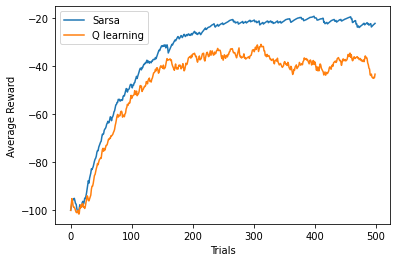

In [107]:
# Plot the rewards averaged over the repeats
plt.plot(np.arange(nTrials), totalSmoothRewards.mean(axis=0), label = 'Sarsa')
plt.plot(np.arange(nTrials), totalSmoothRewardsQ.mean(axis=0), label='Q learning')

plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.legend()
plt.show()